## Handling the Data

#### Import packages

In [49]:
import os
import glob
import re
import random
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image


#### Extracting a subset of training data

In [50]:
def extract_realism_score(file_name):
    match = re.search(r'r(\d+\.\d+)_', file_name)
    if match:
        return float(match.group(1))
    else:
        print(f"Could not extract realism score from {file_name}")
        return None

example_filename = "r0.50_00228_05516.png"
print(f"Extracted realism score: {extract_realism_score(example_filename)}")


Extracted realism score: 0.5


In [51]:
toy_dataset = "Flux+Real_10k 5/"

if not os.path.exists(toy_dataset):
    print(f"The dataset path {toy_dataset} does not exist.")
else:
    image_paths = glob.glob(os.path.join(toy_dataset, "*.png"))
    print(f"Found {len(image_paths)} images in the dataset.")

Found 1279 images in the dataset.


#### Visualizing few images

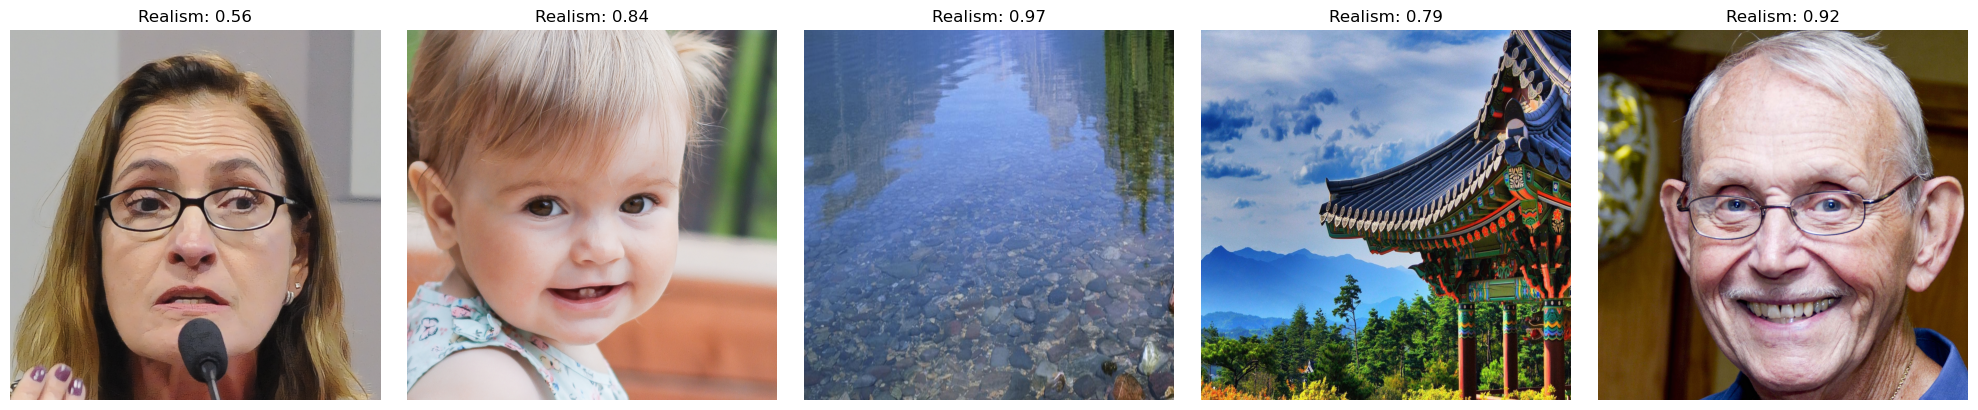

In [52]:
num_to_display = 5

fig, axes = plt.subplots(1, num_to_display, figsize=(20, 4))

for i in range(num_to_display):
    image_path = random.choice(image_paths)
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Realism: {extract_realism_score(os.path.basename(image_path))}")

plt.tight_layout()
plt.show()

## Data Preprocessing and Analysis

In [72]:
def preprocess_image_1(image_path, target_size= (224, 224)):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image)

def preprocess_image_2(image_path, target_size= (224, 224)):
    image = Image.open(image_path).convert("RGB")
    image = image.resize(target_size)
    image_array = np.array(image, dtype=np.float32) / 255
    return image_array

test_image_path = image_paths[0]
test_image_1 = preprocess_image_1(test_image_path)
test_image_2 = preprocess_image_2(test_image_path)
print("Shape of the preprocessed image using method 1:", test_image_1.shape)
print("Shape of the preprocessed image using method 2:", test_image_2.shape)

Shape of the preprocessed image using method 1: torch.Size([3, 224, 224])
Shape of the preprocessed image using method 2: (224, 224, 3)


#### Creating a dataloader

In [76]:
images = []
labels = []

for image_path in image_paths:
    img_array = preprocess_image_1(image_path)
    images.append(img_array)

    score = extract_realism_score(os.path.basename(image_path))
    labels.append(score)

images = np.array(images)
labels = np.array(labels)

print("Dataset shapes:")
print("Images shape: ", images.shape)
print("Labels shape: ", labels.shape)

Dataset shapes:
Images shape:  (1279, 3, 224, 224)
Labels shape:  (1279,)


#### Plotting the distribution of realism scores in the dataset

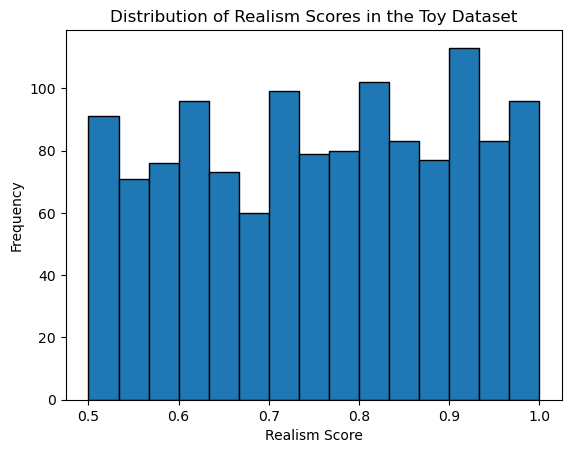

In [77]:
plt.hist(labels, bins=15, edgecolor='black')
plt.xlabel('Realism Score')
plt.ylabel('Frequency')
plt.title('Distribution of Realism Scores in the Toy Dataset')
plt.show()

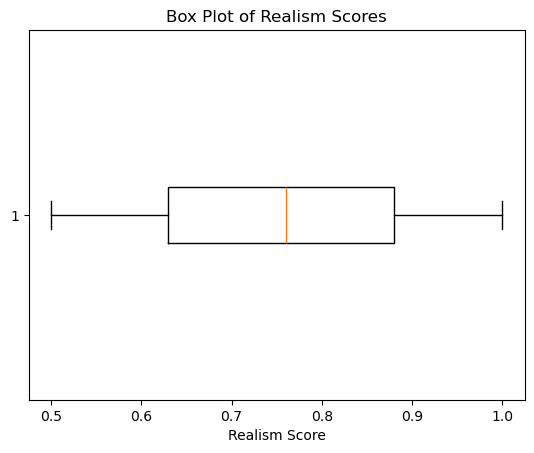

In [78]:
plt.boxplot(labels, vert=False)
plt.xlabel('Realism Score')
plt.title('Box Plot of Realism Scores')
plt.show()

#### Train, validation and test splits

In [79]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print("Training set:")
print("Images shape: ", X_train.shape)
print("Labels shape: ", y_train.shape)
print("Validation set:")
print("Images shape: ", X_val.shape)
print("Labels shape: ", y_val.shape)
print("Test set:")
print("Images shape: ", X_test.shape)
print("Labels shape: ", y_test.shape)

Training set:
Images shape:  (1023, 3, 224, 224)
Labels shape:  (1023,)
Validation set:
Images shape:  (128, 3, 224, 224)
Labels shape:  (128,)
Test set:
Images shape:  (128, 3, 224, 224)
Labels shape:  (128,)


## Model Design

In [80]:
class RegressionResNet(nn.Module):
    def __init__(self):
        super(RegressionResNet, self).__init__()
        self.resnet = models.resnet18(weights=True)

        """
        for param in self.resnet.parameters():
            param.requires_grad = False
        """

        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.resnet(x)
    
model = RegressionResNet()
print(model)

RegressionResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

/opt/anaconda3/envs/ml_ai/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [82]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [85]:
batch_size = 8
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Training and Evaluation

In [86]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device)
print(f"Training on device: {device}")

num_epochs = 20
best_val_loss = float('inf')
early_stopper = 5
early_stopper_counter = 0

Training on device: mps


In [87]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def evaluate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

In [88]:
def compute_metrics(model, loader, device):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu())
            targets.append(labels.cpu())
    
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)

    mse = nn.MSELoss()(predictions, targets).item()
    mae = nn.L1Loss()(predictions, targets).item()
    # Compute R-squared: 1 - SSE / SST

    sse = torch.sum((targets - predictions) ** 2).item()
    sst = torch.sum((targets - torch.mean(targets)) ** 2).item()
    r_squared = 1 - sse / sst if sst > 0 else 0
    return mse, mae, r_squared
    

In [89]:
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = evaluate_epoch(model, val_loader, criterion, device)
    mse, mae, r_squared = compute_metrics(model, val_loader, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
    print(f"Val Metrics --> MSE: {mse:.4f} | MAE: {mae:.4f} | R2: {r_squared:.4f}")

    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        early_stopper_counter = 0
    else:
        early_stopper_counter += 1
        if early_stopper_counter >= early_stopper:
            print("Early stopping triggered.")
            break

Epoch 1/20
Train Loss: 0.3929 - Val Loss: 0.0335
Val Metrics --> MSE: 0.0335 | MAE: 0.1485 | R2: -0.5619
Epoch 2/20
Train Loss: 0.0324 - Val Loss: 0.0345
Val Metrics --> MSE: 0.0345 | MAE: 0.1520 | R2: -0.6094
Epoch 3/20
Train Loss: 0.0266 - Val Loss: 0.0255
Val Metrics --> MSE: 0.0255 | MAE: 0.1365 | R2: -0.1900
Epoch 4/20
Train Loss: 0.0286 - Val Loss: 0.0302
Val Metrics --> MSE: 0.0302 | MAE: 0.1466 | R2: -0.4090
Epoch 5/20
Train Loss: 0.0287 - Val Loss: 0.0228
Val Metrics --> MSE: 0.0228 | MAE: 0.1272 | R2: -0.0652
Epoch 6/20
Train Loss: 0.0265 - Val Loss: 0.0288
Val Metrics --> MSE: 0.0288 | MAE: 0.1417 | R2: -0.3413
Epoch 7/20
Train Loss: 0.0229 - Val Loss: 0.0297
Val Metrics --> MSE: 0.0297 | MAE: 0.1451 | R2: -0.3871
Epoch 8/20
Train Loss: 0.0239 - Val Loss: 0.0381
Val Metrics --> MSE: 0.0381 | MAE: 0.1525 | R2: -0.7768
Epoch 9/20
Train Loss: 0.0217 - Val Loss: 0.0217
Val Metrics --> MSE: 0.0217 | MAE: 0.1191 | R2: -0.0125
Epoch 10/20
Train Loss: 0.0196 - Val Loss: 0.0359
Val M

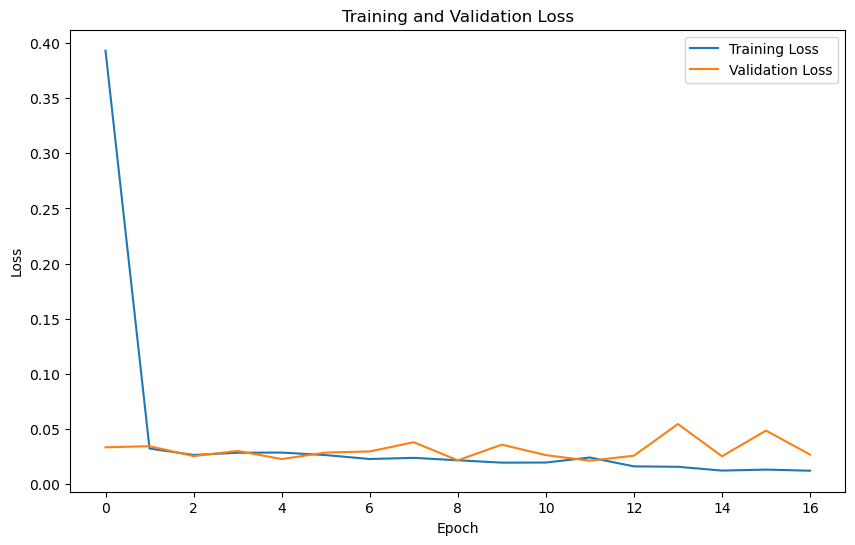

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()